<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Bet_sizing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling

     |████████████████████████████████| 153kB 3.5MB/s 


## META-LABELING

### What is meta labeling?

The first step is to train a primary model (binary classification). 

Second a threshold level is determined at which the primary model has a high recall, in the coded example you will find that 0.30 is a good threshold, ROC curves could be used to help determine a good level. 

Third the features from the first model are concatenated with the predictions from the first model, into a new feature set for the secondary model. Meta Labels are used as the target variable in the second model. 
Now fit the second model. 

Fourth the prediction from the secondary model is combined with the prediction from the primary model and only where both are true, is your final prediction true. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

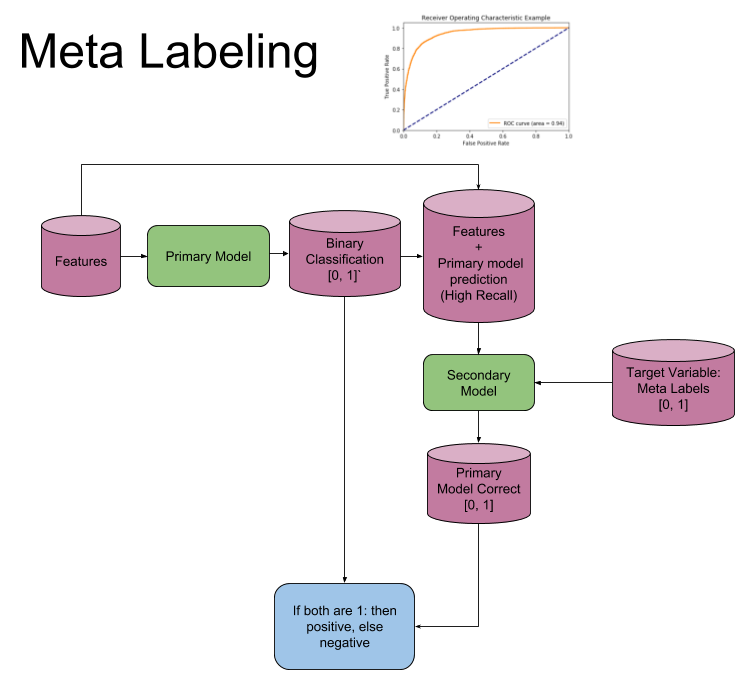

In [6]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

### Read in data - dollar bars

In [7]:
# make dollar bars from tick data
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1_000_000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [8]:
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:35,62,50.79,51.07,50.710,51.07,19844,13264,62,1.010425e+06
2009-09-28 09:53:49,108,51.07,51.15,51.050,51.14,20324,16274,46,1.038593e+06
2009-09-28 09:55:26,143,51.14,51.15,51.129,51.14,19622,13098,35,1.003401e+06
2009-09-28 10:02:52,201,51.14,51.26,51.080,51.25,22319,17454,58,1.142880e+06
2009-09-28 10:10:21,254,51.25,51.29,51.190,51.29,21519,14254,53,1.103149e+06


In [0]:
close = dollar_bars.close

### Primary model (side) 
- Based on the simple moving average cross-over strategy.

In [0]:
fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

side = df['side']

In [11]:
side.value_counts()

 1.0    32190
-1.0    26367
Name: side, dtype: int64

In [0]:
# form a tripple-barrier
pt_sl = [1,2]

target = util.get_daily_vol(close,lookback=50)

h = target.mean()*0.5
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter get t_events

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=1)

In [13]:
# events
min_ret = 0.005

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)

# label (bin)

bin = labeling.get_bins(events, close)

2020-01-25 06:26:18.007255 100.0% apply_pt_sl_on_t1 done after 0.22 minutes. Remaining 0.0 minutes.


In [14]:
bin.describe()

,ret,trgt,bin,side
count,6404.000000,6410.000000,6410.000000,6404.000000
mean,-0.000117,0.009983,0.312012,-0.059963
std,0.013082,0.006454,0.463351,0.998279
min,-0.237752,0.005000,0.000000,-1.000000
25%,-0.007115,0.006446,0.000000,-1.000000
50%,0.001033,0.008225,0.000000,-1.000000
75%,0.007684,0.011075,1.000000,1.000000
max,0.373211,0.094337,1.000000,1.000000


In [0]:
bin.dropna(inplace=True)

In [16]:
bin.side.value_counts()

-1.0    3394
 1.0    3010
Name: side, dtype: int64

In [17]:
bin.bin.value_counts()

0    4404
1    2000
Name: bin, dtype: int64

In [0]:
raw_data = pd.DataFrame(close)

log_ret = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)

# Volatility
raw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [19]:
raw_X = raw_data.iloc[:,1:]
raw_X.dropna(inplace=True)
raw_X.head()

,mom1,mom2,mom3,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3
date_time,,,,,,,,,
2009-09-30 15:42:01,-0.005646,-0.006353,-0.007579,0.002705,0.003341,0.003551,-0.051927,0.216036,-0.302316
2009-09-30 15:58:56,0.001371,-0.004283,-0.004991,0.002705,0.003353,0.003594,-0.071628,0.205664,-0.310500
2009-10-01 09:30:07,0.000391,0.001762,-0.003894,0.002706,0.003347,0.003583,-0.070389,0.189256,-0.312039
2009-10-01 09:39:37,-0.003518,-0.003129,-0.001762,0.002733,0.003394,0.003663,-0.078848,0.180343,-0.242727
2009-10-01 09:52:26,-0.002942,-0.006450,-0.006062,0.002759,0.003416,0.003565,-0.048314,0.173996,-0.255830


In [20]:
# Feature decomposition PCA

n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)

X['side'] = side

X.head()

,0,1,2,3,4,side
date_time,,,,,,
2009-09-30 15:42:01,0.093435,-0.355411,-0.010021,0.011007,0.003954,-1.0
2009-09-30 15:58:56,0.103315,-0.353263,-0.031490,0.005555,0.003636,-1.0
2009-10-01 09:30:07,0.093653,-0.345701,-0.042566,0.001394,0.003241,-1.0
2009-10-01 09:39:37,0.108490,-0.282626,-0.015056,0.004202,0.003426,-1.0
2009-10-01 09:52:26,0.077217,-0.294765,-0.010693,0.009079,0.003859,-1.0


In [21]:
len(X)

58556

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join([bin.bin, events['t1']])
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:6]
y = tmp_data[['bin']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

In [0]:
#avgU = sampling.get_av_uniqueness_from_triple_barrier(events, close, 3).mean()
#max_samples = avgU[0]

In [0]:
#clf0 = RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
#clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, max_features=1, n_estimators=1000)
#clf1.fit(X_train, y_train.values.ravel())

#this is the method in the book

In [29]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 50, 100, 512, 1000]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False)
clf = GridSearchCV(rf, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oo

In [0]:
#y_pred = clf1.predict(X_test)
#y_pred_prob = clf1.predict_proba(X_test)[:, 1] # 1로 예상할 확률

In [0]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

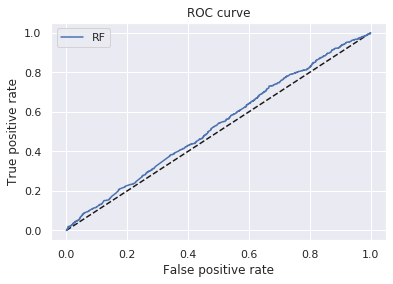

In [33]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob)

%matplotlib inline

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       0.65      0.46      0.54      1616
         1.0       0.39      0.58      0.46       946

    accuracy                           0.50      2562
   macro avg       0.52      0.52      0.50      2562
weighted avg       0.55      0.50      0.51      2562

Accuracy =  0.5035128805620609

Confusion Matrix


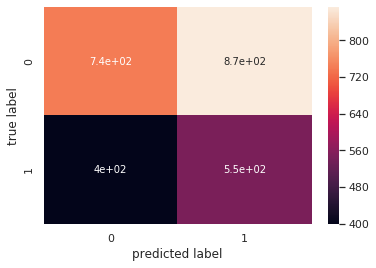

In [34]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

## Bet Sizing

In [0]:
from mlfinlab import bet_sizing as bs

In [0]:
p = y_pred_prob

In [37]:
new_data = y_test.copy()
new_data['p'] = p
new_data['pred'] = y_pred
new_data

,bin,p,pred
date_time,,,
2015-07-09 09:56:21,0.0,0.567667,1.0
2015-07-09 12:00:31,0.0,0.559007,1.0
2015-07-09 15:59:28,1.0,0.616522,1.0
2015-07-10 09:35:27,1.0,0.616522,1.0
2015-07-10 11:48:00,1.0,0.574191,1.0
...,...,...,...
2019-06-12 11:59:18,0.0,0.559007,1.0
2019-06-13 09:36:29,0.0,0.559509,1.0
2019-06-18 09:50:22,0.0,0.368544,0.0


In [0]:
# test에 맞추자
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [39]:
bs_df

,t1,trgt,side,pt,sl,bin,p,pred
date_time,,,,,,,,
2015-07-09 09:56:21,2015-07-10 09:56:51,0.008702,-1.0,1,2,0.0,0.567667,1.0
2015-07-09 12:00:31,2015-07-10 12:27:37,0.007981,-1.0,1,2,0.0,0.559007,1.0
2015-07-09 15:59:28,2015-07-10 09:35:27,0.006833,1.0,1,2,1.0,0.616522,1.0
2015-07-10 09:35:27,2015-07-13 09:30:23,0.006412,1.0,1,2,1.0,0.616522,1.0
2015-07-10 11:48:00,2015-07-13 09:30:23,0.005870,1.0,1,2,1.0,0.574191,1.0
...,...,...,...,...,...,...,...,...
2019-06-12 11:59:18,2019-06-13 12:16:14,0.005909,-1.0,1,2,0.0,0.559007,1.0
2019-06-13 09:36:29,2019-06-14 09:48:52,0.005255,-1.0,1,2,0.0,0.559509,1.0
2019-06-18 09:50:22,2019-06-19 09:57:29,0.005684,-1.0,1,2,0.0,0.368544,0.0


### bet size probability

In [0]:
m_prob = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3)

In [41]:
m_prob

date_time
2015-07-09 09:56:21    0.108646
2015-07-09 12:00:31    0.094602
2015-07-09 15:59:28    0.189392
2015-07-10 09:35:27    0.189392
2015-07-10 11:48:00    0.119269
                         ...   
2019-06-12 11:59:18    0.094602
2019-06-13 09:36:29    0.095414
2019-06-18 09:50:22   -0.214761
2019-06-18 12:22:51   -0.044367
2019-06-19 14:01:58   -0.609154
Name: signal, Length: 2562, dtype: float64

average

In [42]:
m_prob_avg = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True)
m_prob_avg

2020-01-25 06:41:56.824596 100.0% mp_avg_active_signals done after 0.17 minutes. Remaining 0.0 minutes.


2015-07-09 09:56:21    0.108646
2015-07-09 12:00:31    0.101624
2015-07-09 15:59:28    0.130880
2015-07-10 09:35:27    0.130880
2015-07-10 09:56:51    0.141997
                         ...   
2019-06-18 12:22:51   -0.129564
2019-06-19 09:57:29   -0.044367
2019-06-19 12:33:36    0.000000
2019-06-19 14:01:58   -0.609154
2019-06-20 09:30:00    0.000000
Length: 3830, dtype: float64

In [43]:
m_prob_discrete = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True, step_size=0.01)
m_prob_discrete

2020-01-25 06:42:07.440236 100.0% mp_avg_active_signals done after 0.17 minutes. Remaining 0.0 minutes.


2015-07-09 09:56:21    0.11
2015-07-09 12:00:31    0.10
2015-07-09 15:59:28    0.13
2015-07-10 09:35:27    0.13
2015-07-10 09:56:51    0.14
                       ... 
2019-06-18 12:22:51   -0.13
2019-06-19 09:57:29   -0.04
2019-06-19 12:33:36    0.00
2019-06-19 14:01:58   -0.61
2019-06-20 09:30:00    0.00
Length: 3830, dtype: float64

### bet size reserve

In [44]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=50)

|#########################| Completed 50 of 50 fitting rounds.

In [45]:
m_reserve[0]

,t1,side,active_long,active_short,c_t,bet_size
date_time,,,,,,
2015-07-09 09:56:21,2015-07-10 09:56:51,-1.0,0,1,-1,-0.151861
2015-07-09 12:00:31,2015-07-10 12:27:37,-1.0,0,2,-2,-0.305167
2015-07-09 15:59:28,2015-07-10 09:35:27,1.0,1,2,-1,-0.151861
2015-07-10 09:35:27,2015-07-13 09:30:23,1.0,1,2,-1,-0.151861
2015-07-10 11:48:00,2015-07-13 09:30:23,1.0,2,1,1,0.213739
...,...,...,...,...,...,...
2019-06-12 11:59:18,2019-06-13 12:16:14,-1.0,3,1,2,0.405732
2019-06-13 09:36:29,2019-06-14 09:48:52,-1.0,0,2,-2,-0.305167
2019-06-18 09:50:22,2019-06-19 09:57:29,-1.0,0,1,-1,-0.151861


In [0]:
BetSizeReserve = m_reserve[0].bet_size

In [47]:
m_reserve[1]
#parameter for two Gaussian mixture

{'mu_1': -1.44952,
 'mu_2': 3.71153,
 'p_1': 0.92797,
 'sigma_1': 4.10773,
 'sigma_2': 2.85437}

### bet size budget

In [48]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
date_time,,,,,
2015-07-09 09:56:21,2015-07-10 09:56:51,-1.0,0,1,-0.035714
2015-07-09 12:00:31,2015-07-10 12:27:37,-1.0,0,2,-0.071429
2015-07-09 15:59:28,2015-07-10 09:35:27,1.0,1,2,0.000000
2015-07-10 09:35:27,2015-07-13 09:30:23,1.0,1,2,0.000000
2015-07-10 11:48:00,2015-07-13 09:30:23,1.0,2,1,0.107143
...,...,...,...,...,...
2019-06-12 11:59:18,2019-06-13 12:16:14,-1.0,3,1,0.178571
2019-06-13 09:36:29,2019-06-14 09:48:52,-1.0,0,2,-0.071429
2019-06-18 09:50:22,2019-06-19 09:57:29,-1.0,0,1,-0.035714


In [0]:
BetSizeBudget = m_budget.bet_size

overview

In [50]:
bet_size_0 = pd.DataFrame({'BetSizeProb':m_prob,'BetSizeProbAvg':m_prob_avg,'BetSizeProbDiscrete':m_prob_discrete})
bet_size_1 = bet_size_0.join(BetSizeReserve)
bet_size = bet_size_1.join(BetSizeBudget,rsuffix='2')
bet_size = bet_size.rename(columns={'bet_size':'BetSizeReserve', 'bet_size2':'BetSizeBudget'})
bet_size

,BetSizeProb,BetSizeProbAvg,BetSizeProbDiscrete,BetSizeReserve,BetSizeBudget
2015-07-09 09:56:21,0.108646,0.108646,0.11,-0.151861,-0.035714
2015-07-09 12:00:31,0.094602,0.101624,0.10,-0.305167,-0.071429
2015-07-09 15:59:28,0.189392,0.130880,0.13,-0.151861,0.000000
2015-07-10 09:35:27,0.189392,0.130880,0.13,-0.151861,0.000000
2015-07-10 09:56:51,NaN,0.141997,0.14,NaN,NaN
...,...,...,...,...,...
2019-06-18 12:22:51,-0.044367,-0.129564,-0.13,0.000000,0.035714
2019-06-19 09:57:29,NaN,-0.044367,-0.04,NaN,NaN
2019-06-19 12:33:36,NaN,0.000000,0.00,NaN,NaN
2019-06-19 14:01:58,-0.609154,-0.609154,-0.61,0.213739,0.071429


In [0]:
bet_size.dropna(inplace=True)

Plot

Text(0.5, 1.0, 'Bet Size 100 points')

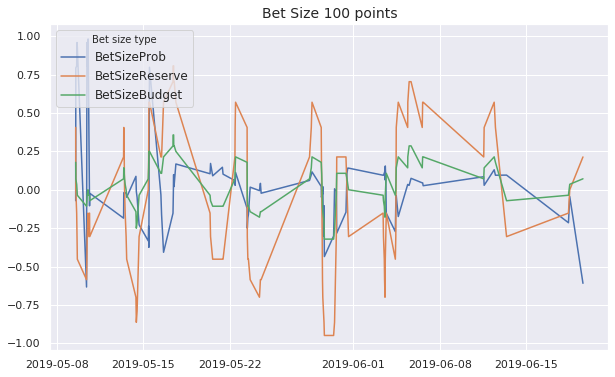

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_3 = bet_size.drop(['BetSizeProbAvg','BetSizeProbDiscrete'],axis=1)
ax.plot(bet_size_3[-100:])

ax.legend(labels=bet_size_3.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Prob 100 points')

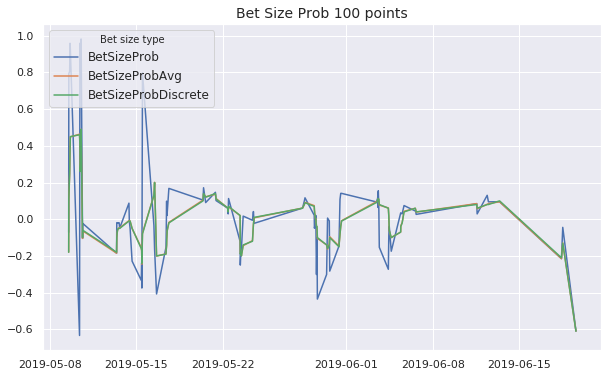

In [53]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_4 = bet_size.iloc[:,:3]
ax.plot(bet_size_4[-100:])

ax.legend(labels=bet_size_4.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size Prob 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

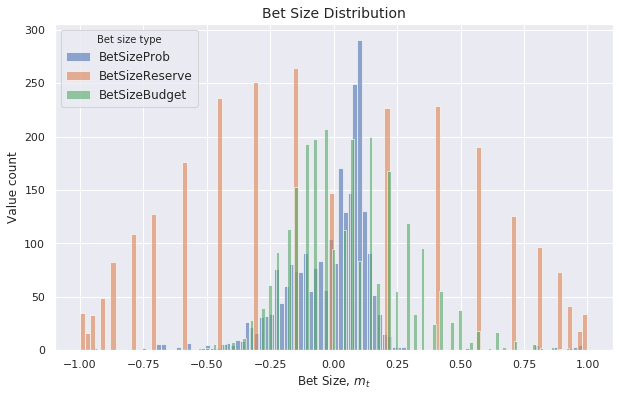

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProb','BetSizeReserve', 'BetSizeBudget']:
    ax.hist(bet_size_3[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

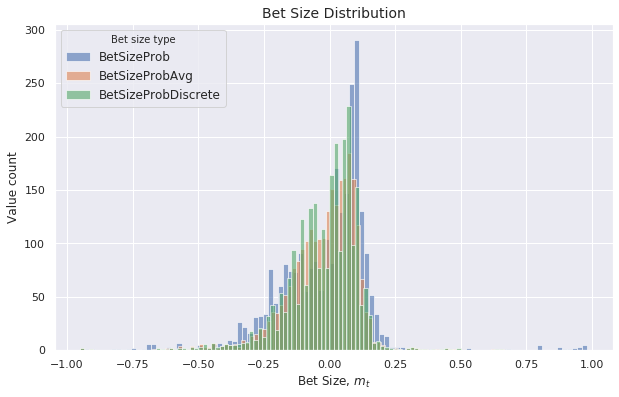

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProb','BetSizeProbAvg', 'BetSizeProbDiscrete']:
    ax.hist(bet_size_4[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

## REFERENCE

Advances in Financial Machine Learning, Lopez de Prado

https://github.com/hudson-and-thames/research